# Codespaces

Copilot codespaces is free for an edu account. It allows you to "upload" hints and source material. The [`hep-programming-hints`](https://github.com/gordonwatts/hep-programming-hints) repo was used. As the code had trouble running various things, that repo was updated (without re-running previously run questions). GPT 4.1 was used as the model. The [code space can be found here](https://github.com/copilot/spaces/gordonwatts/1) (this might not be accessible to anyone but me).

Note that when testing this was writing Release 25 code, and that was not yet released for ServiceX.

## Question 1: ETmiss

Prompt: `Plot the ETmiss of all events in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697`

[Codespace Query]()

Modifications:

* It mistakenly things you can access `met()` directly from the container rather than fetching the first MET object.
    * Added code to the hints database that details how to get at the missing et (re-running the query and it did it correctly).
* Removed the `ak.flatten`.
* Added the backend since `atlasr25` isn't on production yet.
* Added a `plt.show()` (which is ok - the instructions explicitly tell it not to do that).

Output()

c:\Users\gordo\Code\iris-hep\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


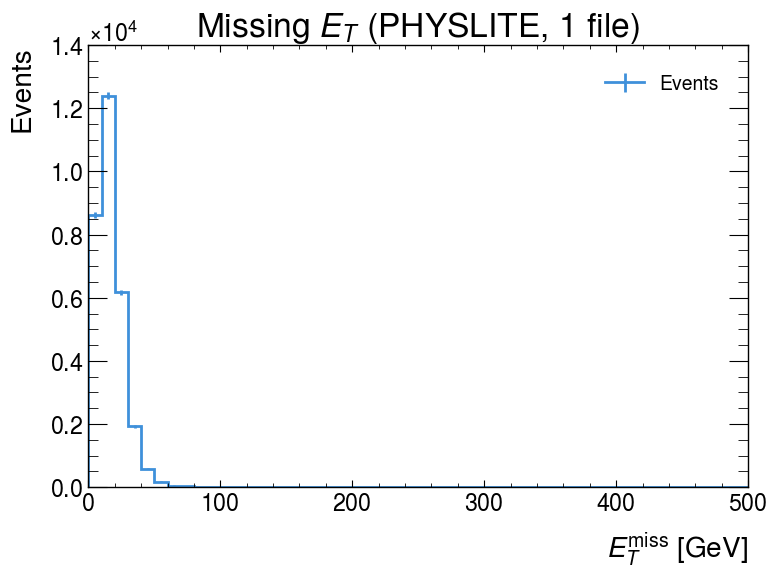

Saved ETmiss histogram as etmiss_hist.png


<Figure size 800x600 with 0 Axes>

In [10]:
import awkward as ak
import vector
import matplotlib.pyplot as plt
import mplhep as hep
from hist import Hist

from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset

# Register vector behaviors for awkward arrays (not strictly needed for ETmiss, but good practice)
vector.register_awkward()

# Step 1: Build the query to get ETmiss for each event
base_query = FuncADLQueryPHYSLITE()

# In PHYSLITE, MET is stored as a sequence per event; we want the first (and only) one
etmiss_query = base_query.Select(lambda e: e.MissingET().First()).Select(
    lambda met: {"etmiss": met.met() / 1000.0}
)  # GeV

# Step 2: Deliver the data from ServiceX (use only 1 file for quick test; remove NFiles for full dataset)
ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"
result = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="etmiss_fetch",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,  # Remove or increase for full production
                    Query=etmiss_query,
                )
            ]
        ),
        servicex_name="servicex-release-prod",
    )
)

etmiss = result["etmiss_fetch"].etmiss  # awkward array of ETmiss per event

# Step 3: Flatten and convert to numpy for histogramming
etmiss_flat = ak.to_numpy(etmiss)

# Step 4: Make the histogram
h = Hist.new.Reg(
    50, 0, 500, name="etmiss", label=r"$E_{T}^{\mathrm{miss}}$ [GeV]"
).Int64()
h.fill(etmiss=etmiss_flat)

# Step 5: Plot with mplhep
plt.style.use(hep.style.ATLAS)
fig, ax = plt.subplots()
h.plot(ax=ax, histtype="step", linewidth=2, label="Events")
ax.set_xlabel(r"$E_{T}^{\mathrm{miss}}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("Missing $E_T$ (PHYSLITE, 1 file)")
ax.legend()
plt.tight_layout()
plt.show()
plt.savefig("etmiss_hist.png")
print("Saved ETmiss histogram as etmiss_hist.png")

## Question 2: All Jets

Prompt: `Plot the jet pT for all jets in mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697`

Using this [codespace](https://github.com/copilot/spaces/gordonwatts/1). Here is the [query](https://github.com/copilot/c/1aab4eb2-2ee9-462f-a2d7-0cb18a099e47).

Modifications made to the raw code below:

* Remove the `ak.flatten` around the result (the `SelectMany` already does that). Initial attempts to alter the hints did not fix this problem.
* Added the backend since `atlasr25` isn't on production yet.
* Added a `plt.show()` (which is ok - the instructions explicitly tell it not to do that).

Output()

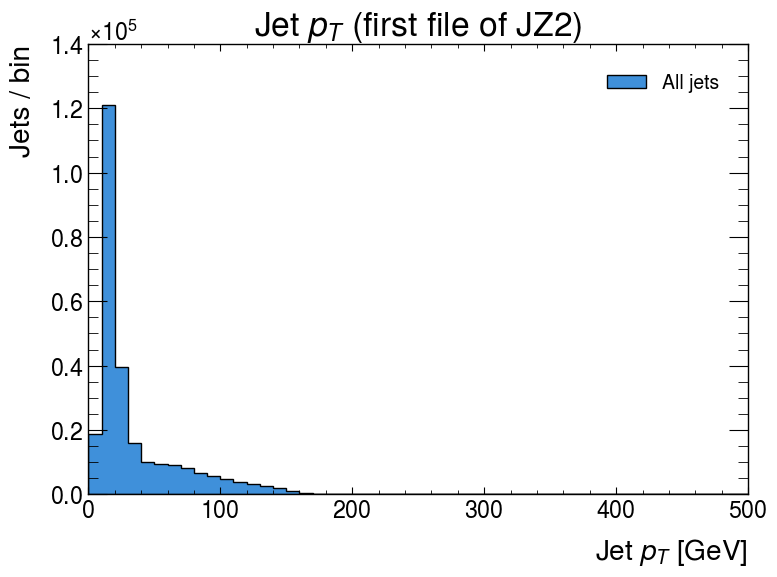

In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
from hist import Hist
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset

# 1. Build the query for jet pt (in GeV) from the dataset
base_query = FuncADLQueryPHYSLITE()
jet_pts_query = (
    base_query
    .SelectMany(lambda evt: evt.Jets())
    .Select(lambda jet: {
        "jet_pt": jet.pt() / 1000.0,  # GeV
    })
)

ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"

# 2. Fetch awkward array from ServiceX (limit to 1 file for speed)
all_jet_pts = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="jet_pt_fetch",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,
                    Query=jet_pts_query,
                )
            ]
        ),
        servicex_name="servicex-release-prod",
    )
)

# 3. Extract jet pT values
jet_pt = all_jet_pts["jet_pt_fetch"].jet_pt

# 4. Build the histogram for jet pT (0 to 500 GeV, 50 bins)
hist_jet_pt = (
    Hist.new
        .Reg(50, 0, 500, name="jet_pt", label="Jet $p_T$ [GeV]")
        .Int64()
)
hist_jet_pt.fill(jet_pt=jet_pt)

# 5. Plot and save
plt.style.use(hep.style.ATLAS)
hist_jet_pt.plot(histtype="fill", linewidth=1, edgecolor="black", label="All jets")
plt.xlabel("Jet $p_T$ [GeV]")
plt.ylabel("Jets / bin")
plt.title("Jet $p_T$ (first file of JZ2)")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("jet_pt.png")
plt.close()

## 3. Central jets

Prompt: `Plot the pT of jets with |η| < 1 in the rucio dataset mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697`

[Codespace Query](https://github.com/copilot/c/65bcb7d2-a047-47a9-9755-2194dee727b2)

Modifications:

- Remove the `ak.flatten`.
- note: it added `import vector` even though it didn't need it.
- Changed the servicex backend
- Add a `plt.show()`.

Output()

c:\Users\gordo\Code\iris-hep\atlas-plot-agent\.venv\Lib\site-packages\mplhep\utils.py:577: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


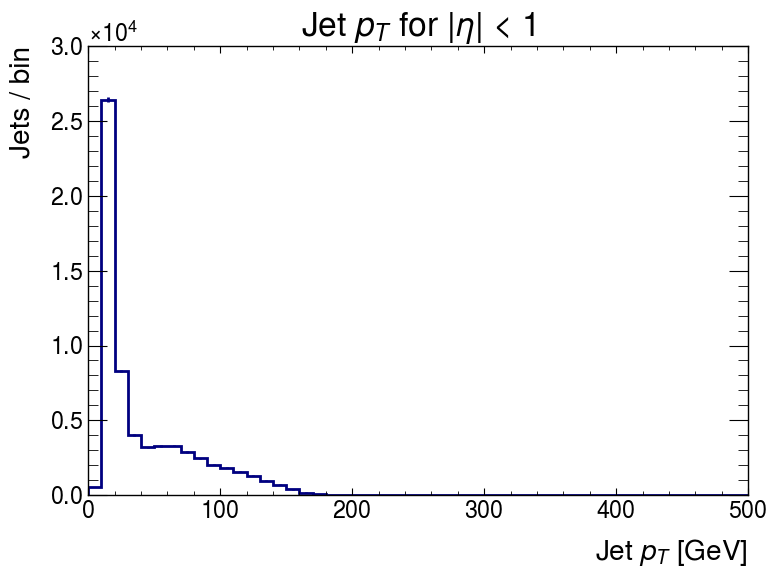

In [4]:
import awkward as ak
import vector
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex_analysis_utils import to_awk
from servicex import deliver, ServiceXSpec, Sample, dataset
from hist import Hist
import matplotlib.pyplot as plt
import mplhep as hep

# Register vector behaviors for awkward arrays
vector.register_awkward()

# Define the dataset name
ds_name = "mc23_13p6TeV:mc23_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.deriv.DAOD_PHYSLITE.e8514_e8528_a911_s4114_r15224_r15225_p6697"

# Define the query: get jets with |eta| < 1 and fetch their pt (in GeV)
base_query = FuncADLQueryPHYSLITE()
jet_query = (
    base_query.SelectMany(lambda evt: evt.Jets())
    .Where(lambda jet: abs(jet.eta()) < 1.0)
    .Select(
        lambda jet: {
            "pt": jet.pt() / 1000.0,  # Convert to GeV
        }
    )
)

# Deliver the query and fetch the results (use only 1 file for speed in demo; remove NFiles to run on all)
result = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="jet_pt_eta_lt1",
                    Dataset=dataset.Rucio(ds_name),
                    NFiles=1,
                    Query=jet_query,
                )
            ]
        ),
        servicex_name="servicex-release-prod",
    )
)

# Extract pt awkward array
jet_pts = result["jet_pt_eta_lt1"].pt

# Plot histogram with Hist
h = Hist.new.Reg(50, 0, 500, name="pt", label="Jet $p_T$ [GeV]").Int64()
h.fill(pt=jet_pts)

plt.style.use(hep.style.ATLAS)
h.plot(histtype="step", linewidth=2, color="navy")
plt.xlabel(r"Jet $p_T$ [GeV]")
plt.ylabel("Jets / bin")
plt.title(r"Jet $p_T$ for |$\eta$| < 1")
plt.tight_layout()
plt.show()
plt.savefig("jet_pt_eta_lt1.png")
plt.close()